# IF3070 Foundations of Artificial Intelligence | Tugas Besar 2

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: 07

Group Members:
- Bryan P. Hutagalung (18222130)
- Ardra Rafif Sahasika (18222134)
- Timothy Haposan Simanjuntak (18222137)
- Yusril Fazri Mahendra (18222141)

## Import Libraries

In [896]:
# Basic Data Manipulation
import numpy as np
import pandas as pd
from typing import List, Dict
from tqdm.auto import tqdm

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Scikit-learn
## Core Components
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

## Model Selection & Metrics
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_val_score,
    StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc
)

## Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Custom Models
from lib.knn import knn
from lib.gnb import gnb

# Configure Warnings
import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [897]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
test_ids = test['id'].copy()

y_train = train['label']
X_train = train.drop('label', axis=1)

train = pd.read_csv('../data/train.csv')

pd.set_option('display.max_columns', None)

In [898]:
train.head()

,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,1,NaN,https://www.northcm.ac.th,24.0,www.northcm.ac.th,17.0,0.0,NaN,0.800000,NaN,NaN,NaN,2.0,0.0,NaN,0.0,NaN,0.417,0.0,0.000,0.0,0.0,0.0,2.0,0.083,NaN,NaN,457.0,NaN,norhcmac,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,5.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,1.0,NaN,3.0,NaN,69.0,NaN,NaN,1
1,4,8135291.txt,http://uqr.to/1il1z,NaN,NaN,NaN,NaN,to,1.000000,0.000896,0.036850,2.0,0.0,NaN,0.0,NaN,8.0,0.421,2.0,0.105,NaN,NaN,0.0,2.0,NaN,NaN,9.0,NaN,1.0,NaN,NaN,100.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0
2,5,586561.txt,https://www.woolworthsrewards.com.au,35.0,www.woolworthsrewards.com.au,28.0,0.0,au,0.857143,NaN,0.060894,NaN,2.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,woolworthsrewrdscom,0.0,0.0,1.0,0.0,1.0,NaN,1.0,NaN,0.0,3.0,0.0,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,33.0,7.0,8.0,15.0,NaN,2.0,1
3,6,NaN,NaN,31.0,NaN,NaN,NaN,com,0.562500,0.522907,0.055829,NaN,1.0,NaN,0.0,NaN,17.0,NaN,0.0,0.000,NaN,0.0,0.0,NaN,0.065,NaN,NaN,5062.0,NaN,NaN,100.0,100.0,NaN,0.0,NaN,0.0,0.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,24.0,5.0,14.0,NaN,NaN,NaN,1
4,11,412632.txt,NaN,NaN,www.nyprowrestling.com,22.0,0.0,NaN,1.000000,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0.0,0.000,NaN,0.0,NaN,1.0,0.034,1.0,766.0,NaN,NaN,nyprowrestling,100.0,100.0,1.0,1.0,NaN,0.0,NaN,1.0,0.0,0.0,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,14.0,NaN,0.0,NaN,1


In [899]:
test.head()

,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
0,48,80851.txt,https://www.iaee.org,19.0,NaN,12.0,0.0,org,NaN,0.079963,0.081395,3.0,1.0,NaN,0.0,NaN,6.0,0.316,0.0,0.00,0.0,NaN,NaN,1.0,NaN,1.0,NaN,1864.0,NaN,iaee,100.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,1.0,NaN,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,13.0,194.0,NaN,65.0
1,68,mw130480.txt,http://www.iran-edi.com,22.0,NaN,16.0,NaN,NaN,0.625000,NaN,0.069183,3.0,1.0,0.0,0.0,NaN,NaN,0.409,0.0,0.00,0.0,0.0,0.0,2.0,0.091,0.0,49.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,1.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,2.0,0.0,0.0,1.0
2,76,400382.txt,https://www.bistum-chur.ch,25.0,www.bistum-chur.ch,18.0,0.0,ch,0.636364,0.004983,0.050344,2.0,NaN,0.0,0.0,0.0,11.0,0.440,0.0,0.00,NaN,NaN,0.0,2.0,0.080,NaN,634.0,9381.0,1.0,bistum-hur,0.0,0.0,1.0,NaN,1.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,0.0,1.0,5.0,12.0,18.0,193.0,NaN,196.0
3,155,625297.txt,https://www.numberthreebath.com,30.0,NaN,23.0,NaN,com,1.000000,0.522907,0.059065,3.0,1.0,0.0,0.0,0.0,17.0,0.567,NaN,0.00,0.0,0.0,0.0,NaN,NaN,1.0,229.0,711.0,1.0,numberthreebath,100.0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,10.0,12.0,0.0,11.0
4,167,8123642.txt,https://ipfs.litnet.work/ipfs/bafybeib5jvxytzb...,100.0,ipfs.litnet.work,NaN,0.0,work,NaN,NaN,0.035754,NaN,1.0,0.0,0.0,0.0,NaN,0.750,NaN,0.11,0.0,0.0,NaN,NaN,0.060,1.0,88.0,NaN,1.0,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN


## Constants

In [900]:
# Define the target feature
TARGET = 'label'

def identify_feature_types(df: pd.DataFrame) -> Dict[str, List[str]]:
    try:
        # Initial identification of numerical and categorical features
        num_feats = df.select_dtypes(include=[np.number]).columns.tolist()
        cat_feats = df.select_dtypes(exclude=[np.number]).columns.tolist()
        
        # Identify boolean features
        bool_feats = []
        for col in num_feats:
            unique_vals = set(df[col].dropna().unique())
            if unique_vals.issubset({0, 1, 0.0, 1.0, True, False}) and 'NoOf' not in col:
                bool_feats.append(col)
        
        # Update numerical and categorical features
        num_feats = [col for col in num_feats if col not in bool_feats]
        cat_feats = cat_feats + bool_feats
        
        # Convert categorical features to category dtype
        df[cat_feats] = df[cat_feats].astype('category')
        
        return {
            'numerical': num_feats,
            'categorical': cat_feats,
            'boolean': bool_feats
        }
        
    except Exception as e:
        print(f"Error identifying feature types: {str(e)}")
        return {
            'numerical': [],
            'categorical': [],
            'boolean': []
        }

# Get feature types
feature_types = identify_feature_types(train)

# Access different feature types
NUM_FEATS = feature_types['numerical']
CAT_FEATS = feature_types['categorical']
BOOL_FEATS = feature_types['boolean']

# Define theme and color map
THEME = 'indigo'
CMAP_COLOUR = LinearSegmentedColormap.from_list(THEME, ['#E6E6FA', '#4B0082'])

# 1. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train` folder given by the TA. The `test` data is only used for kaggle submission.

In [901]:
train_dev, test_set = train_test_split(train, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_dev, test_size=0.25, random_state=42)

y_train_set = train_set[TARGET]
X_train_set = train_set.drop(columns=TARGET)

y_val_set = val_set[TARGET]
X_val_set = val_set.drop(columns=TARGET)

y_test_set = test_set[TARGET]
X_test_set = test_set.drop(columns=TARGET)

train_dev, test_set = train_test_split(train, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_dev, test_size=0.25, random_state=42)

# Get feature types
feature_types = identify_feature_types(train)

# Access different feature types
NUM_FEATS = feature_types['numerical']
CAT_FEATS = feature_types['categorical']
BOOL_FEATS = feature_types['boolean']

In [902]:
train_set.head()

,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
122689,206014,66721.txt,https://www.visitdallas.com,NaN,NaN,19.0,0.0,com,NaN,0.522907,0.058301,NaN,NaN,0.0,NaN,0.0,13.0,0.500,NaN,0.0,NaN,0.0,0.0,1.0,NaN,1.0,3975.0,61394.0,1.0,visitdallas,NaN,100.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,NaN,1.0,36.0,NaN,8.0,123.0,NaN,138.0,1
47918,80162,NaN,NaN,NaN,www.everydayann.com,NaN,0.0,NaN,NaN,0.522907,0.058676,NaN,NaN,NaN,0.0,0.0,13.0,0.500,0.0,NaN,NaN,0.0,0.0,1.0,NaN,1.0,NaN,9587.0,NaN,NaN,NaN,100.0,1.0,1.0,1.0,NaN,0.0,NaN,0.0,0.0,1.0,NaN,1.0,1.0,NaN,0.0,1.0,0.0,NaN,17.0,13.0,17.0,60.0,0.0,NaN,1
5961,9970,20200.txt,https://www.zippyshare.com,NaN,www.zippyshare.com,18.0,NaN,com,NaN,0.522907,0.051626,3.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,100.0,100.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,28.0,22.0,NaN,NaN,3.0,1
55357,92544,NaN,NaN,NaN,NaN,NaN,0.0,com,1.0,0.522907,NaN,NaN,NaN,0.0,NaN,NaN,9.0,NaN,NaN,NaN,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,100.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,1.0,1.0,0.0,1.0,39.0,2.0,12.0,51.0,1.0,6.0,1
28327,47379,732535.txt,https://www.americanrootsuk.com,NaN,NaN,23.0,NaN,NaN,NaN,0.522907,NaN,NaN,1.0,NaN,NaN,0.0,17.0,0.567,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,14435.0,1335.0,NaN,americanrootsuk,100.0,100.0,0.0,NaN,1.0,0.0,0.0,1.0,0.0,3.0,NaN,1.0,NaN,1.0,0.0,NaN,NaN,NaN,0.0,NaN,4.0,8.0,1034.0,0.0,1.0,1


In [903]:
val_set.head()

,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
69198,115699,mw29719.txt,NaN,31.0,www.atomzlogs.com.xsph.ru,NaN,0.0,ru,0.555556,0.018013,0.055402,2.0,3.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.097,0.0,9.0,44.0,NaN,atomzlogscomxsph,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0
122213,205234,NaN,https://www.chickychickyblingbling.com,37.0,www.chickychickyblingbling.com,NaN,0.0,com,NaN,0.522907,NaN,NaN,1.0,NaN,NaN,NaN,24.0,0.649,NaN,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,chickychickyblingbling,NaN,100.0,0.0,NaN,NaN,NaN,0.0,1.0,0.0,NaN,0.0,NaN,1.0,NaN,1.0,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,2.0,NaN,1
118277,198698,NaN,NaN,NaN,www.skid.sh,11.0,0.0,sh,NaN,0.000303,0.040745,2.0,1.0,0.0,0.0,NaN,6.0,0.333,0.0,NaN,NaN,0.0,0.0,1.0,0.056,NaN,2.0,27.0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0
40210,67197,NaN,https://www.timecamp.com,NaN,www.timecamp.com,16.0,0.0,com,NaN,0.522907,0.068583,3.0,1.0,NaN,0.0,NaN,10.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.043,NaN,1920.0,NaN,1.0,NaN,100.0,100.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.0,0.0,NaN,0.0,1.0,NaN,1.0,NaN,9.0,12.0,NaN,0.0,53.0,1
53462,89376,226129.txt,https://www.shakespeares-sonnets.com,35.0,NaN,NaN,0.0,NaN,0.650000,0.522907,0.065427,NaN,1.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.057,1.0,NaN,477.0,1.0,NaN,100.0,100.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,3.0,NaN,NaN,310.0,NaN,NaN,1


In [904]:
test_set.head()

,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
8409,14051,819722.txt,https://www.citroencarclub.org.uk,NaN,NaN,25.0,0.0,uk,NaN,0.028555,0.061899,2.0,NaN,0.0,0.0,NaN,18.0,0.562,NaN,0.0,0.0,0.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN,citroencarclborg,NaN,NaN,1.0,1.0,1.0,NaN,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,20.0,27.0,2.0,14.0,NaN,1
20959,34872,NaN,https://www.flipyourtext.com,NaN,www.flipyourtext.com,NaN,0.0,com,NaN,0.522907,NaN,3.0,1.0,0.0,0.0,NaN,NaN,0.519,NaN,0.0,NaN,0.0,NaN,1.0,NaN,NaN,144.0,717.0,NaN,flipyourtext,100.0,100.0,1.0,0.0,1.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,2.0,NaN,9.0,8.0,0.0,NaN,1
88797,148915,254644.txt,NaN,25.0,NaN,18.0,0.0,NaN,NaN,0.522907,NaN,3.0,1.0,0.0,NaN,NaN,12.0,NaN,0.0,0.0,NaN,0.0,0.0,1.0,0.040,1.0,NaN,152070.0,NaN,trustytaxi,100.0,NaN,1.0,NaN,1.0,NaN,NaN,0.0,0.0,2.0,0.0,1.0,NaN,NaN,0.0,NaN,1.0,NaN,1.0,3.0,3.0,NaN,2.0,NaN,2.0,1
24345,40612,NaN,https://www.elcalafate.gov.ar,28.0,NaN,NaN,NaN,NaN,NaN,NaN,0.062508,2.0,NaN,0.0,0.0,0.0,14.0,NaN,NaN,0.0,NaN,NaN,0.0,2.0,0.071,1.0,723.0,NaN,NaN,elclftegov,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,1.0,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN,NaN,40.0,82.0,2.0,NaN,1
95019,159405,NaN,https://www.dongwon.com,22.0,NaN,NaN,0.0,NaN,1.0,0.522907,0.062712,3.0,1.0,NaN,NaN,0.0,NaN,0.409,0.0,0.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,0.0,NaN,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,0.0,0.0,1.0,NaN,12.0,9.0,63.0,NaN,NaN,1


In [905]:
train_set.shape, val_set.shape, test_set.shape

((84242, 56), (28081, 56), (28081, 56))

# 2. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

We will give some common methods for you to try, but you only have to **at least implement one method for each process**. For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

## A. Data Cleaning

**Data cleaning** is the crucial first step in preparing your dataset for machine learning. Raw data collected from various sources is often messy and may contain errors, missing values, and inconsistencies. Data cleaning involves the following steps:

1. **Handling Missing Data:** Identify and address missing values in the dataset. This can include imputing missing values, removing rows or columns with excessive missing data, or using more advanced techniques like interpolation.

2. **Dealing with Outliers:** Identify and handle outliers, which are data points significantly different from the rest of the dataset. Outliers can be removed or transformed to improve model performance.

3. **Data Validation:** Check for data integrity and consistency. Ensure that data types are correct, categorical variables have consistent labels, and numerical values fall within expected ranges.

4. **Removing Duplicates:** Identify and remove duplicate rows, as they can skew the model's training process and evaluation metrics.

5. **Feature Engineering**: Create new features or modify existing ones to extract relevant information. This step can involve scaling, normalizing, or encoding features for better model interpretability.

### I. Handling Missing Data

Missing data can adversely affect the performance and accuracy of machine learning models. There are several strategies to handle missing data in machine learning:

1. **Data Imputation:**

    a. **Mean, Median, or Mode Imputation:** For numerical features, you can replace missing values with the mean, median, or mode of the non-missing values in the same feature. This method is simple and often effective when data is missing at random.

    b. **Constant Value Imputation:** You can replace missing values with a predefined constant value (e.g., 0) if it makes sense for your dataset and problem.

    c. **Imputation Using Predictive Models:** More advanced techniques involve using predictive models to estimate missing values. For example, you can train a regression model to predict missing numerical values or a classification model to predict missing categorical values.

2. **Deletion of Missing Data:**

    a. **Listwise Deletion:** In cases where the amount of missing data is relatively small, you can simply remove rows with missing values from your dataset. However, this approach can lead to a loss of valuable information.

    b. **Column (Feature) Deletion:** If a feature has a large number of missing values and is not critical for your analysis, you can consider removing that feature altogether.

3. **Domain-Specific Strategies:**

    a. **Domain Knowledge:** In some cases, domain knowledge can guide the imputation process. For example, if you know that missing values are related to a specific condition, you can impute them accordingly.

4. **Imputation Libraries:**

    a. **Scikit-Learn:** Scikit-Learn provides a `SimpleImputer` class that can handle basic imputation strategies like mean, median, and mode imputation.

    b. **Fancyimpute:** Fancyimpute is a Python library that offers more advanced imputation techniques, including matrix factorization, k-nearest neighbors, and deep learning-based methods.

The choice of imputation method should be guided by the nature of your data, the amount of missing data, the problem you are trying to solve, and the assumptions you are willing to make.

#### 1. Data Imputation

In [906]:
class BasicImputationHandler(BaseEstimator, TransformerMixin):
    def __init__(self, num_feats, cat_feats, method='mean'):
        """
        Basic imputation using mean/median/mode
        method: 'mean', 'median', 'mode'
        """
        self.num_feats = num_feats
        self.cat_feats = cat_feats
        self.method = method
        self.fill_values = {}

    def fit(self, X, y=None):
        for column in X.columns:
            if column in self.cat_feats:
                self.fill_values[column] = X[column].mode().iloc[0]
            elif column in self.num_feats:
                if self.method == 'mean':
                    self.fill_values[column] = X[column].mean()
                elif self.method == 'median':
                    self.fill_values[column] = X[column].median()
        return self

    def transform(self, X):
        X = X.copy()
        for column, value in self.fill_values.items():
            X[column] = X[column].fillna(value)
        return X

#### 2. Deletion of Missing Data

In [907]:
class DeletionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.5, method='listwise'):
        """
        Missing data deletion
        method: 'listwise', 'columnwise'
        threshold: for columnwise deletion
        """
        self.threshold = threshold
        self.method = method
        self.cols_to_drop = None

    def fit(self, X, y=None):
        if self.method == 'columnwise':
            missing_ratio = X.isnull().mean()
            self.cols_to_drop = missing_ratio[missing_ratio > self.threshold].index
        return self

    def transform(self, X):
        X = X.copy()
        if self.method == 'listwise':
            return X.dropna()
        elif self.method == 'columnwise':
            return X.drop(columns=self.cols_to_drop)

#### 3. Domain-Specific Strategies

In [908]:
class DomainHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method='url'):
        """
        Domain-specific handling
        method: 'url', 'boolean', 'ratio'
        """
        self.method = method
        self.patterns = {
            'url': {'URL': 'https://example.com', 'Domain': 'example.com'},
            'boolean': {'IsHTTPS': 0, 'HasObfuscation': 0},
            'ratio': {'LetterRatioInURL': 0.0, 'DigitRatioInURL': 0.0}
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col, value in self.patterns[self.method].items():
            if col in X.columns:
                X[col] = X[col].fillna(value)
        return X

#### 4. Imputation Libraries

In [909]:
class AdvancedImputationHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method='knn', n_neighbors=5):
        """
        Advanced imputation methods
        method: 'knn', 'iterative', 'matrix'
        """
        self.method = method
        self.n_neighbors = n_neighbors
        if method == 'knn':
            self.imputer = KNNImputer(n_neighbors=n_neighbors)
        elif method == 'iterative':
            self.imputer = IterativeImputer()
        else:
            self.imputer = SimpleImputer(strategy='mean')

    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(
            self.imputer.transform(X),
            columns=X.columns,
            index=X.index
        )

#### Compile

In [910]:
missing_imputation = BasicImputationHandler(
    num_feats=NUM_FEATS,
    cat_feats=CAT_FEATS,
    method='mean'
)

missing_deletion = DeletionHandler(
    method='listwise'
)

missing_domain = DomainHandler(
    method='url_based'
)

missing_advanced = AdvancedImputationHandler(
    method='knn'
)

### II. Dealing with Outliers

Outliers are data points that significantly differ from the majority of the data. They can be unusually high or low values that do not fit the pattern of the rest of the dataset. Outliers can significantly impact model performance, so it is important to handle them properly.

Some methods to handle outliers:
1. **Imputation**: Replace with mean, median, or a boundary value.
2. **Clipping**: Cap values to upper and lower limits.
3. **Transformation**: Use log, square root, or power transformations to reduce their influence.
4. **Model-Based**: Use algorithms robust to outliers (e.g., tree-based models, Huber regression).

#### 1. Imputation

In [911]:
class ImputationOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, num_feats, method='median', threshold=1.5):
        """
        Handle outliers by imputing with mean/median/mode
        method: 'mean', 'median', 'mode'
        threshold: IQR multiplier for outlier detection
        """
        self.num_feats = num_feats
        self.method = method
        self.threshold = threshold
        self.replacement_values = {}

    def fit(self, X, y=None):
        for col in self.num_feats:
            if self.method == 'median':
                self.replacement_values[col] = X[col].median()
            elif self.method == 'mean':
                self.replacement_values[col] = X[col].mean()
            elif self.method == 'mode':
                self.replacement_values[col] = X[col].mode()[0]
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.num_feats:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.threshold * IQR
            upper_bound = Q3 + self.threshold * IQR
            
            # Replace outliers with the chosen statistic
            mask = (X[col] < lower_bound) | (X[col] > upper_bound)
            X.loc[mask, col] = self.replacement_values[col]
        return X

#### 2. Clipping

In [912]:
class ClippingOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, num_feats, threshold=1.5):
        """
        Handle outliers by clipping to boundaries
        threshold: IQR multiplier for outlier detection
        """
        self.num_feats = num_feats
        self.threshold = threshold
        self.bounds = {}

    def fit(self, X, y=None):
        for col in self.num_feats:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.bounds[col] = {
                'lower': Q1 - self.threshold * IQR,
                'upper': Q3 + self.threshold * IQR
            }
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.num_feats:
            X[col] = X[col].clip(
                lower=self.bounds[col]['lower'],
                upper=self.bounds[col]['upper']
            )
        return X

#### 3. Transformation

In [913]:
class TransformationOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, num_feats, method='log'):
        """
        Handle outliers using transformations
        method: 'log', 'sqrt', 'box-cox'
        """
        self.num_feats = num_feats
        self.method = method

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.num_feats:
            if self.method == 'log':
                # Add small constant to handle zeros
                X[col] = np.log1p(X[col] - X[col].min() + 1)
            elif self.method == 'sqrt':
                X[col] = np.sqrt(X[col] - X[col].min())
            elif self.method == 'box-cox':
                from scipy import stats
                X[col] = stats.boxcox(X[col] - X[col].min() + 1)[0]
        return X

#### 4. Model-Based

In [914]:
class ModelBasedOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, num_feats, contamination=0.1):
        """
        Handle outliers using isolation forest
        contamination: proportion of outliers in the dataset
        """
        self.num_feats = num_feats
        self.contamination = contamination
        self.outlier_detector = IsolationForest(
            contamination=contamination,
            random_state=42
        )

    def fit(self, X, y=None):
        self.outlier_detector.fit(X[self.num_feats])
        return self

    def transform(self, X):
        X = X.copy()
        outlier_labels = self.outlier_detector.predict(X[self.num_feats])
        for col in self.num_feats:
            # Replace outliers with median of non-outlier values
            median_val = X.loc[outlier_labels == 1, col].median()
            X.loc[outlier_labels == -1, col] = median_val
        return X

#### Compile

In [915]:
outlier_imputation = ImputationOutlierHandler(
    num_feats=NUM_FEATS,
    method='median',
    threshold=1.5
)

outlier_clipping = ClippingOutlierHandler(
    num_feats=NUM_FEATS,
    threshold=1.5
)

outlier_transformation = TransformationOutlierHandler(
    num_feats=NUM_FEATS,
    method='log'
)

outlier_model = ModelBasedOutlierHandler(
    num_feats=NUM_FEATS,
    contamination=0.1
)

### III. Remove Duplicates
Handling duplicate values is crucial because they can compromise data integrity, leading to inaccurate analysis and insights. Duplicate entries can bias machine learning models, causing overfitting and reducing their ability to generalize to new data. They also inflate the dataset size unnecessarily, increasing computational costs and processing times. Additionally, duplicates can distort statistical measures and lead to inconsistencies, ultimately affecting the reliability of data-driven decisions and reporting. Ensuring data quality by removing duplicates is essential for accurate, efficient, and consistent analysis.

In [916]:
def handle_duplicates(train_set, val_set, test_set, verbose=True):
    """
    Handle duplicates in datasets with analysis and reporting
    """
    if verbose:
        # Print initial stats
        print("Initial shapes:")
        print(f"Train set: {train_set.shape}")
        print(f"Validation set: {val_set.shape}") 
        print(f"Test set: {test_set.shape}")
        print("\nChecking for duplicates...")
        
        # Analyze duplicates
        train_dups = train_set.duplicated().sum()
        val_dups = val_set.duplicated().sum()
        test_dups = test_set.duplicated().sum()
        
        print(f"\nDuplicates found:")
        print(f"Train set: {train_dups}")
        print(f"Validation set: {val_dups}")
        print(f"Test set: {test_dups}")

    # Remove duplicates while preserving index
    train_set_clean = train_set.drop_duplicates(keep='first')
    val_set_clean = val_set.drop_duplicates(keep='first') 
    test_set_clean = test_set.drop_duplicates(keep='first')

    if verbose:
        # Print final stats
        print("\nFinal shapes after removing duplicates:")
        print(f"Train set: {train_set_clean.shape}")
        print(f"Validation set: {val_set_clean.shape}")
        print(f"Test set: {test_set_clean.shape}")
        
        # Print reduction percentages
        train_reduction = (1 - len(train_set_clean)/len(train_set)) * 100
        val_reduction = (1 - len(val_set_clean)/len(val_set)) * 100
        test_reduction = (1 - len(test_set_clean)/len(test_set)) * 100
        
        print(f"\nReduction percentages:")
        print(f"Train set: {train_reduction:.2f}%")
        print(f"Validation set: {val_reduction:.2f}%") 
        print(f"Test set: {test_reduction:.2f}%")

    return train_set_clean, val_set_clean, test_set_clean

# Use the function
train_set, val_set, test_set = handle_duplicates(train_set, val_set, test_set)

Initial shapes:
Train set: (84242, 56)
Validation set: (28081, 56)
Test set: (28081, 56)

Checking for duplicates...

Duplicates found:
Train set: 0
Validation set: 0
Test set: 0

Final shapes after removing duplicates:
Train set: (84242, 56)
Validation set: (28081, 56)
Test set: (28081, 56)

Reduction percentages:
Train set: 0.00%
Validation set: 0.00%
Test set: 0.00%


### IV. Feature Engineering

**Feature engineering** involves creating new features (input variables) or transforming existing ones to improve the performance of machine learning models. Feature engineering aims to enhance the model's ability to learn patterns and make accurate predictions from the data. It's often said that "good features make good models."

1. **Feature Selection:** Feature engineering can involve selecting the most relevant and informative features from the dataset. Removing irrelevant or redundant features not only simplifies the model but also reduces the risk of overfitting.

2. **Creating New Features:** Sometimes, the existing features may not capture the underlying patterns effectively. In such cases, engineers create new features that provide additional information. For example:
   
   - **Polynomial Features:** Engineers may create new features by taking the square, cube, or other higher-order terms of existing numerical features. This can help capture nonlinear relationships.
   
   - **Interaction Features:** Interaction features are created by combining two or more existing features. For example, if you have features "length" and "width," you can create an "area" feature by multiplying them.

3. **Binning or Discretization:** Continuous numerical features can be divided into bins or categories. For instance, age values can be grouped into bins like "child," "adult," and "senior."

4. **Domain-Specific Feature Engineering:** Depending on the domain and problem, engineers may create domain-specific features. For example, in fraud detection, features related to transaction history and user behavior may be engineered to identify anomalies.

Feature engineering is both a creative and iterative process. It requires a deep understanding of the data, domain knowledge, and experimentation to determine which features will enhance the model's predictive power.

#### 1. Feature Selection

In [917]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Feature selection using multiple methods:
    - Initial column dropping (id, FILENAME, etc.)
    - Correlation-based
    - Mutual information
    - Variance threshold
    """
    def __init__(self, num_feats, cat_feats, method='correlation', threshold=0.1, target_col='label'):
        self.num_feats = num_feats
        self.cat_feats = cat_feats
        self.method = method
        self.threshold = threshold
        self.selected_features = None
        self.target_col = target_col
        # Columns to always drop
        self.drop_columns = ['id', 'FILENAME', 'URL', 'Domain', 'TLD', 'Title']
        
    def fit(self, X, y=None):
        # First drop specified columns
        X_temp = X.copy()
        if y is not None:
            X_temp[self.target_col] = y  # Add target column for correlation
            
        self.columns_to_drop = [col for col in self.drop_columns if col in X_temp.columns]
        X_temp = X_temp.drop(columns=self.columns_to_drop)
        
        if self.method == 'correlation':
            # Calculate correlation matrix
            numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
            corr_matrix = X_temp[numeric_cols].corr()
            
            if self.target_col in corr_matrix.columns:
                # Get correlation with target
                target_corr = abs(corr_matrix[self.target_col])
                # Select features above threshold
                self.selected_features = target_corr[target_corr > self.threshold].index
            else:
                self.selected_features = numeric_cols
        
        elif self.method == 'mutual_info':
            # Use mutual information for feature selection
            selector = SelectKBest(score_func=mutual_info_classif, k=20)
            selector.fit(X_temp[self.num_feats], y)
            self.selected_features = X_temp[self.num_feats].columns[selector.get_support()]
            
        # Update feature lists
        self.num_feats = [col for col in self.num_feats if col not in self.columns_to_drop]
        self.cat_feats = [col for col in self.cat_feats if col not in self.columns_to_drop]
            
        return self
        
    def transform(self, X):
        # First drop specified columns
        X_transformed = X.drop(columns=self.columns_to_drop)
        
        # Then apply feature selection if specified
        if self.selected_features is not None:
            features_to_keep = [col for col in self.selected_features if col != self.target_col]
            X_transformed = X_transformed[features_to_keep]
            
        return X_transformed

#### 2. Creating New Features

In [918]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    """
    Create new features with controlled growth:
    - Limited polynomial features for important features only 
    - Selected interaction terms
    - Key ratios
    """
    def __init__(self, num_feats, max_features=50):
        self.num_feats = num_feats
        self.max_features = max_features
        # Define most important features to create derivatives
        self.important_features = [
            'URLLength', 
            'DomainLength',
            'NoOfLettersInURL',
            'NoOfDigitsInURL',
            'CharContinuationRate'
        ]
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X = X.copy()
        feature_count = len(X.columns)
        
        # Polynomial features only for important features
        if feature_count < self.max_features:
            for col in self.important_features:
                if col in X.columns:
                    X[f'{col}_squared'] = X[col] ** 2
                    feature_count += 1
                    if feature_count >= self.max_features:
                        return X
        
        # Key ratios
        important_ratios = [
            ('URLLength', 'DomainLength'),
            ('NoOfLettersInURL', 'URLLength'),
            ('NoOfDigitsInURL', 'URLLength'),
            ('NoOfObfuscatedChar', 'URLLength'),
            ('NoOfSpecialCharsInURL', 'URLLength')
        ]
        
        if feature_count < self.max_features:
            for num, denom in important_ratios:
                if num in X.columns and denom in X.columns:
                    X[f'{num}_{denom}_ratio'] = X[num] / (X[denom] + 1e-6)
                    feature_count += 1
                    if feature_count >= self.max_features:
                        return X
        
        # Selected interactions
        important_interactions = [
            ('URLLength', 'CharContinuationRate'),
            ('DomainLength', 'NoOfSubDomain'),
            ('NoOfLettersInURL', 'NoOfDigitsInURL'),
            ('NoOfSpecialCharsInURL', 'ObfuscationRatio')
        ]
        
        if feature_count < self.max_features:
            for feat1, feat2 in important_interactions:
                if feat1 in X.columns and feat2 in X.columns:
                    X[f'{feat1}_{feat2}_interaction'] = X[feat1] * X[feat2]
                    feature_count += 1
                    if feature_count >= self.max_features:
                        return X
                        
        return X

#### 3. Binning or Discretization

In [919]:
class FeatureBinner(BaseEstimator, TransformerMixin):
    """
    Bin continuous features into categories:
    - Equal-width binning
    - Equal-frequency binning
    - Custom binning
    """
    def __init__(self, num_feats, method='equal_width', n_bins=5):
        self.num_feats = num_feats
        self.method = method
        self.n_bins = n_bins
        self.bin_edges = {}
        
    def fit(self, X, y=None):
        for col in self.num_feats:
            if col in X.columns:
                if self.method == 'equal_width':
                    self.bin_edges[col] = np.linspace(
                        X[col].min(), 
                        X[col].max(), 
                        self.n_bins + 1
                    )
                elif self.method == 'equal_freq':
                    self.bin_edges[col] = np.percentile(
                        X[col].dropna(),
                        np.linspace(0, 100, self.n_bins + 1)
                    )
        return self
        
    def transform(self, X):
        X = X.copy()
        for col, edges in self.bin_edges.items():
            if col in X.columns:
                X[f'{col}_binned'] = pd.cut(
                    X[col], 
                    bins=edges, 
                    labels=[f'bin_{i}' for i in range(self.n_bins)]
                )
        return X

#### 4. Domain-Specific

In [920]:
class DomainFeatureCreator(BaseEstimator, TransformerMixin):
    """
    Create domain-specific features for URL analysis:
    - URL structure features
    - Security indicators
    - Pattern matching
    """
    def __init__(self):
        self.suspicious_patterns = [
            r'login', r'admin', r'bank', r'secure',
            r'password', r'verify', r'account'
        ]
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X = X.copy()
        
        # URL structure features
        X['HasSubdomain'] = X['Domain'].apply(
            lambda x: len(str(x).split('.')) > 2 if pd.notnull(x) else False
        )
        X['PathDepth'] = X['URL'].apply(
            lambda x: len(str(x).split('/')) - 3 if pd.notnull(x) else 0
        )
        
        # Security indicators
        X['IsHTTPS'] = X['URL'].apply(
            lambda x: str(x).startswith('https') if pd.notnull(x) else False
        )
        X['HasSSL'] = X['URL'].apply(
            lambda x: 'ssl' in str(x).lower() if pd.notnull(x) else False
        )
        
        # Suspicious patterns
        for pattern in self.suspicious_patterns:
            X[f'Contains_{pattern}'] = X['URL'].apply(
                lambda x: bool(re.search(pattern, str(x), re.I)) if pd.notnull(x) else False
            )
            
        return X

#### Compile

In [921]:
feature_selection = FeatureSelector(
    num_feats=NUM_FEATS,
    cat_feats=CAT_FEATS,
    method='correlation',
    threshold=0.1,
    target_col='label'
)

feature_creator = FeatureCreator(
    num_feats=NUM_FEATS,
    max_features=15
)

feature_binner = FeatureBinner(
    num_feats=NUM_FEATS,
    method='equal_width',
    n_bins=5
)

feature_domain = DomainFeatureCreator()

## B. Data Preprocessing

**Data preprocessing** is a broader step that encompasses both data cleaning and additional transformations to make the data suitable for machine learning algorithms. Its primary goals are:

1. **Feature Scaling:** Ensure that numerical features have similar scales. Common techniques include Min-Max scaling (scaling to a specific range) or standardization (mean-centered, unit variance).

2. **Encoding Categorical Variables:** Machine learning models typically work with numerical data, so categorical variables need to be encoded. This can be done using one-hot encoding, label encoding, or more advanced methods like target encoding.

3. **Handling Imbalanced Classes:** If dealing with imbalanced classes in a binary classification task, apply techniques such as oversampling, undersampling, or using different evaluation metrics to address class imbalance.

4. **Dimensionality Reduction:** Reduce the number of features using techniques like Principal Component Analysis (PCA) or feature selection to simplify the model and potentially improve its performance.

5. **Normalization:** Normalize data to achieve a standard distribution. This is particularly important for algorithms that assume normally distributed data.

### Notes on Preprocessing processes

It is advised to create functions or classes that have the same/similar type of inputs and outputs, so you can add, remove, or swap the order of the processes easily. You can implement the functions or classes by yourself

or

use `sklearn` library. To create a new preprocessing component in `sklearn`, implement a corresponding class that includes:
1. Inheritance to `BaseEstimator` and `TransformerMixin`
2. The method `fit`
3. The method `transform`

### I. Feature Scaling

**Feature scaling** is a preprocessing technique used in machine learning to standardize the range of independent variables or features of data. The primary goal of feature scaling is to ensure that all features contribute equally to the training process and that machine learning algorithms can work effectively with the data.

Here are the main reasons why feature scaling is important:

1. **Algorithm Sensitivity:** Many machine learning algorithms are sensitive to the scale of input features. If the scales of features are significantly different, some algorithms may perform poorly or take much longer to converge.

2. **Distance-Based Algorithms:** Algorithms that rely on distances or similarities between data points, such as k-nearest neighbors (KNN) and support vector machines (SVM), can be influenced by feature scales. Features with larger scales may dominate the distance calculations.

3. **Regularization:** Regularization techniques, like L1 (Lasso) and L2 (Ridge) regularization, add penalty terms based on feature coefficients. Scaling ensures that all features are treated equally in the regularization process.

Common methods for feature scaling include:

1. **Min-Max Scaling (Normalization):** This method scales features to a specific range, typically [0, 1]. It's done using the following formula:

   $$X' = \frac{X - X_{min}}{X_{max} - X_{min}}$$

   - Here, $X$ is the original feature value, $X_{min}$ is the minimum value of the feature, and $X_{max}$ is the maximum value of the feature.  
<br />
<br />
2. **Standardization (Z-score Scaling):** This method scales features to have a mean (average) of 0 and a standard deviation of 1. It's done using the following formula:

   $$X' = \frac{X - \mu}{\sigma}$$

   - $X$ is the original feature value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.  
<br />
<br />
3. **Robust Scaling:** Robust scaling is a method that scales features to the interquartile range (IQR) and is less affected by outliers. It's calculated as:

   $$X' = \frac{X - Q1}{Q3 - Q1}$$

   - $X$ is the original feature value, $Q1$ is the first quartile (25th percentile), and $Q3$ is the third quartile (75th percentile) of the feature.  
<br />
<br />
4. **Log Transformation:** In cases where data is highly skewed or has a heavy-tailed distribution, taking the logarithm of the feature values can help stabilize the variance and improve scaling.

The choice of scaling method depends on the characteristics of your data and the requirements of your machine learning algorithm. **Min-max scaling and standardization are the most commonly used techniques and work well for many datasets.**

Scaling should be applied separately to each training and test set to prevent data leakage from the test set into the training set. Additionally, **some algorithms may not require feature scaling, particularly tree-based models.**

#### 1. Min-Max Scaling (Normalization)

In [922]:
class MinMaxScalerTransformer(BaseEstimator, TransformerMixin):
    """
    Min-Max scaling to [0,1] range
    """
    def __init__(self, num_feats, feature_range=(0,1)):
        self.num_feats = num_feats
        self.feature_range = feature_range
        self.scaler = MinMaxScaler(feature_range=feature_range)
        
    def fit(self, X, y=None):
        self.existing_num_feats = [col for col in self.num_feats if col in X.columns]
        if self.existing_num_feats:
            self.scaler.fit(X[self.existing_num_feats])
        return self
        
    def transform(self, X):
        X = X.copy()
        if self.existing_num_feats:
            X[self.existing_num_feats] = self.scaler.transform(X[self.existing_num_feats])
        return X

#### 2. Standardization (Z-Score Scaling)

In [923]:
class StandardScalerTransformer(BaseEstimator, TransformerMixin):
    """
    Standardization (Z-score normalization)
    Scales features to have mean=0 and variance=1
    """
    def __init__(self, num_feats):
        self.num_feats = num_feats
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        # Only process columns that exist and are numerical
        self.existing_num_feats = [col for col in self.num_feats 
                                 if col in X.columns and X[col].dtype.kind in 'biufc']
        if self.existing_num_feats:
            self.scaler.fit(X[self.existing_num_feats])
        return self
        
    def transform(self, X):
        X = X.copy()
        if self.existing_num_feats:
            # Convert to numpy array for faster processing
            data = X[self.existing_num_feats].values
            X[self.existing_num_feats] = self.scaler.transform(data)
        return X

#### 3. Robust Scaling

In [924]:
class RobustScalerTransformer(BaseEstimator, TransformerMixin):
    """
    Robust scaling using statistics that are robust to outliers
    """
    def __init__(self, num_feats):
        self.num_feats = num_feats
        self.scaler = RobustScaler()
        
    def fit(self, X, y=None):
        self.existing_num_feats = [col for col in self.num_feats if col in X.columns]
        if self.existing_num_feats:
            self.scaler.fit(X[self.existing_num_feats])
        return self
        
    def transform(self, X):
        X = X.copy()
        if self.existing_num_feats:
            X[self.existing_num_feats] = self.scaler.transform(X[self.existing_num_feats])
        return X

#### 4. Log Transformation

In [925]:
class LogScalerTransformer(BaseEstimator, TransformerMixin):
    """
    Log transformation for handling skewed distributions
    """
    def __init__(self, num_feats):
        self.num_feats = num_feats
        
    def fit(self, X, y=None):
        self.existing_num_feats = [col for col in self.num_feats if col in X.columns]
        return self
        
    def transform(self, X):
        X = X.copy()
        if self.existing_num_feats:
            for col in self.existing_num_feats:
                # Add small constant to handle zeros
                X[col] = np.log1p(X[col] - X[col].min() + 1)
        return X

#### Compile

In [926]:
scaler_standard = StandardScalerTransformer(
    num_feats=NUM_FEATS
)

scaler_minmax = MinMaxScalerTransformer(
    num_feats=NUM_FEATS,
    feature_range=(0,1)
)

scaler_robust = RobustScalerTransformer(
    num_feats=NUM_FEATS
)

scaler_log = LogScalerTransformer(
    num_feats=NUM_FEATS
)

### II. Feature Encoding

**Feature encoding**, also known as **categorical encoding**, is the process of converting categorical data (non-numeric data) into a numerical format so that it can be used as input for machine learning algorithms. Most machine learning models require numerical data for training and prediction, so feature encoding is a critical step in data preprocessing.

Categorical data can take various forms, including:

1. **Nominal Data:** Categories with no intrinsic order, like colors or country names.  

2. **Ordinal Data:** Categories with a meaningful order but not necessarily equidistant, like education levels (e.g., "high school," "bachelor's," "master's").

There are several common methods for encoding categorical data:

1. **Label Encoding:**

   - Label encoding assigns a unique integer to each category in a feature.
   - It's suitable for ordinal data where there's a clear order among categories.
   - For example, if you have an "education" feature with values "high school," "bachelor's," and "master's," you can encode them as 0, 1, and 2, respectively.
<br />
<br />
2. **One-Hot Encoding:**

   - One-hot encoding creates a binary (0 or 1) column for each category in a nominal feature.
   - It's suitable for nominal data where there's no inherent order among categories.
   - Each category becomes a new feature, and the presence (1) or absence (0) of a category is indicated for each row.
<br />
<br />
3. **Target Encoding (Mean Encoding):**

   - Target encoding replaces each category with the mean of the target variable for that category.
   - It's often used for classification problems.

#### 1. Label Encoding

In [927]:
class LabelEncodingTransformer(BaseEstimator, TransformerMixin):
    """
    Label encoding: Convert categories to integer labels
    Suitable for ordinal data
    """
    def __init__(self, cat_feats):
        self.cat_feats = cat_feats
        self.label_maps = {}
        
    def fit(self, X, y=None):
        # Create mapping for each categorical feature
        for col in self.cat_feats:
            if col in X.columns:
                unique_values = X[col].unique()
                self.label_maps[col] = {val: idx for idx, val in enumerate(unique_values)}
        return self
        
    def transform(self, X):
        X = X.copy()
        for col, mapping in self.label_maps.items():
            if col in X.columns:
                X[col] = X[col].map(mapping)
        return X

#### 2. One-Hot Encoding

In [928]:
class OneHotEncodingTransformer(BaseEstimator, TransformerMixin):
    """
    One-hot encoding: Create binary columns for each category
    Suitable for nominal data
    """
    def __init__(self, cat_feats):
        self.cat_feats = cat_feats
        self.dummy_columns = {}
        
    def fit(self, X, y=None):
        # Only process categorical columns that exist
        self.existing_cat_feats = [col for col in self.cat_feats if col in X.columns]
        for col in self.existing_cat_feats:
            unique_vals = X[col].unique()
            self.dummy_columns[col] = [f"{col}_{val}" for val in unique_vals]
        return self
        
    def transform(self, X):
        X = X.copy()
        for col in self.existing_cat_feats:
            # Use pandas get_dummies for efficiency
            dummies = pd.get_dummies(X[col], prefix=col, sparse=True)
            # Add missing columns
            for dummy_col in self.dummy_columns[col]:
                if dummy_col not in dummies.columns:
                    dummies[dummy_col] = 0
            X = pd.concat([X, dummies[self.dummy_columns[col]]], axis=1)
            X.drop(col, axis=1, inplace=True)
        return X

#### 3. Target Encoding

In [929]:
class TargetEncodingTransformer(BaseEstimator, TransformerMixin):
    """
    Target encoding: Replace categories with target mean
    Suitable for high cardinality categorical features
    """
    def __init__(self, cat_feats, smoothing=10):
        self.cat_feats = cat_feats
        self.smoothing = smoothing
        self.target_means = {}
        self.global_means = {}
        
    def fit(self, X, y):
        # Calculate global mean for each feature
        for col in self.cat_feats:
            if col in X.columns:
                self.global_means[col] = y.mean()
                
                # Calculate means per category with smoothing
                category_means = {}
                category_counts = X[col].value_counts()
                
                for category in X[col].unique():
                    category_mask = X[col] == category
                    n = category_counts[category]
                    category_mean = y[category_mask].mean()
                    
                    # Apply smoothing
                    smoothed_mean = (n * category_mean + self.smoothing * self.global_means[col]) / (n + self.smoothing)
                    category_means[category] = smoothed_mean
                    
                self.target_means[col] = category_means
        return self
        
    def transform(self, X):
        X = X.copy()
        for col, means in self.target_means.items():
            if col in X.columns:
                # Map values, use global mean for unseen categories
                X[col] = X[col].map(means).fillna(self.global_means[col])
        return X

In [930]:
encoder_label = LabelEncodingTransformer(
    cat_feats=CAT_FEATS
)

encoder_onehot = OneHotEncodingTransformer(
    cat_feats=CAT_FEATS
)

encoder_target = TargetEncodingTransformer(
    cat_feats=CAT_FEATS,
    smoothing=10
)

### III. Handling Imbalanced Dataset

**Handling imbalanced datasets** is important because imbalanced data can lead to several issues that negatively impact the performance and reliability of machine learning models. Here are some key reasons:

1. **Biased Model Performance**:

 - Models trained on imbalanced data tend to be biased towards the majority class, leading to poor performance on the minority class. This can result in misleading accuracy metrics.

2. **Misleading Accuracy**:

 - High overall accuracy can be misleading in imbalanced datasets. For example, if 95% of the data belongs to one class, a model that always predicts the majority class will have 95% accuracy but will fail to identify the minority class.

3. **Poor Generalization**:

 - Models trained on imbalanced data may not generalize well to new, unseen data, especially if the minority class is underrepresented.


Some methods to handle imbalanced datasets:
1. **Resampling Methods**:

 - Oversampling: Increase the number of instances in the minority class by duplicating or generating synthetic samples (e.g., SMOTE).
 - Undersampling: Reduce the number of instances in the majority class to balance the dataset.

2. **Evaluation Metrics**:

 - Use appropriate evaluation metrics such as precision, recall, F1-score, ROC-AUC, and confusion matrix instead of accuracy to better assess model performance on imbalanced data.

3. **Algorithmic Approaches**:

 - Use algorithms that are designed to handle imbalanced data, such as decision trees, random forests, or ensemble methods.
 - Adjust class weights in algorithms to give more importance to the minority class.

#### 1. Resampling Method

In [931]:
class ResamplingHandler(BaseEstimator, TransformerMixin):
    """Handles imbalanced data using resampling techniques"""
    def __init__(self, method='smote', sampling_strategy='auto', random_state=42):
        self.method = method
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        
        if method == 'smote':
            self.sampler = SMOTE(
                sampling_strategy=sampling_strategy,
                random_state=random_state
            )
        elif method == 'undersample':
            self.sampler = RandomUnderSampler(
                sampling_strategy=sampling_strategy,
                random_state=random_state
            )
        elif method == 'combine':
            self.sampler = SMOTEENN(random_state=random_state)
        
    def fit(self, X, y=None):
        self.sampler.fit(X, y)
        return self
        
    def transform(self, X, y=None):
        # Only resample during training
        if y is not None:
            X_resampled, y_resampled = self.sampler.fit_resample(X, y)
            return X_resampled, y_resampled
        return X
        
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X, y)

#### 2. Evaluation Metrics

In [932]:
class MetricsHandler(BaseEstimator, TransformerMixin):
    """
    Provides comprehensive evaluation metrics for imbalanced datasets:
    - Precision-Recall curve
    - ROC curve
    - F1 score
    - Confusion matrix
    """
    def __init__(self):
        self.metrics = {}
        
    def calculate_metrics(self, y_true, y_pred, y_prob=None):
        """
        Calculate classification metrics
        
        Parameters:
            y_true: Ground truth labels
            y_pred: Predicted labels
            y_prob: Prediction probabilities (optional)
        """
        from sklearn.metrics import (
            precision_score, recall_score, f1_score,
            confusion_matrix, classification_report
        )
        
        # Basic metrics
        self.metrics['precision'] = precision_score(y_true, y_pred, average='weighted')
        self.metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
        self.metrics['f1'] = f1_score(y_true, y_pred, average='weighted')
        self.metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
        
        # Advanced metrics if probabilities are provided
        if y_prob is not None:
            # Get probabilities for positive class only
            pos_probs = y_prob[:, 1]
            
            precision, recall, _ = precision_recall_curve(y_true, pos_probs)
            self.metrics['pr_curve'] = (precision, recall)
            
            fpr, tpr, _ = roc_curve(y_true, pos_probs)
            self.metrics['roc_curve'] = (fpr, tpr)
            self.metrics['auc'] = auc(fpr, tpr)
            
        return self.metrics
    
    def plot_curves(self):
        import matplotlib.pyplot as plt
        
        if 'pr_curve' in self.metrics and 'roc_curve' in self.metrics:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
            
            # Plot PR curve
            precision, recall = self.metrics['pr_curve']
            ax1.plot(recall, precision)
            ax1.set_title('Precision-Recall Curve')
            ax1.set_xlabel('Recall')
            ax1.set_ylabel('Precision')
            
            # Plot ROC curve
            fpr, tpr = self.metrics['roc_curve']
            ax2.plot(fpr, tpr)
            ax2.plot([0, 1], [0, 1], 'k--')
            ax2.set_title(f'ROC Curve (AUC = {self.metrics["auc"]:.3f})')
            ax2.set_xlabel('False Positive Rate')
            ax2.set_ylabel('True Positive Rate')
            
            plt.tight_layout()
            plt.show()

#### 3. Algorithmic Approaches

In [933]:
class AlgorithmicHandler(BaseEstimator, TransformerMixin):
    """
    Implements algorithmic approaches for handling imbalanced data:
    - Class weights
    - Cost-sensitive learning
    - Ensemble methods
    """
    def __init__(self, base_estimator, method='weights'):
        self.base_estimator = base_estimator
        self.method = method
        
    def fit(self, X, y):
        if self.method == 'weights':
            # Calculate class weights
            class_weights = dict(zip(
                np.unique(y),
                1 / np.bincount(y)
            ))
            self.base_estimator.set_params(**{'class_weight': class_weights})
            
        elif self.method == 'ensemble':
            from sklearn.ensemble import BaggingClassifier
            self.base_estimator = BaggingClassifier(
                base_estimator=self.base_estimator,
                n_estimators=10,
                random_state=42
            )
            
        self.base_estimator.fit(X, y)
        return self
        
    def predict(self, X):
        return self.base_estimator.predict(X)
        
    def predict_proba(self, X):
        return self.base_estimator.predict_proba(X)

#### 4. Imbalanced Pipeline

In [934]:
class ImbalancedPipeline(Pipeline):
    """Custom pipeline that handles both X and y for imbalanced data"""
    
    def fit_transform(self, X, y=None, **fit_params):
        """Fit and transform with both X and y"""
        Xt = X
        yt = y
        for name, transform in self.steps[:-1]:
            if transform is not None:
                if hasattr(transform, 'fit_transform'):
                    if 'resampling' in name:
                        Xt, yt = transform.fit_transform(Xt, yt)
                    else:
                        Xt = transform.fit_transform(Xt, yt)
        if self._final_estimator is not None:
            self._final_estimator.fit(Xt, yt)
        return Xt, yt
        
    def transform(self, X):
        """Transform without resampling"""
        Xt = X
        for name, transform in self.steps[:-1]:
            if transform is not None:
                if 'resampling' not in name:
                    Xt = transform.transform(Xt)
        return Xt
        
    def predict(self, X):
        """Get predictions"""
        Xt = self.transform(X)
        return self._final_estimator.predict(Xt)
        
    def predict_proba(self, X):
        """Get prediction probabilities"""
        Xt = self.transform(X)
        return self._final_estimator.predict_proba(Xt)

#### Compile

In [935]:
resampling_smote = ResamplingHandler(method='smote')
resampling_under = ResamplingHandler(method='undersample')
resampling_combine = ResamplingHandler(method='combine')

metrics_handler = MetricsHandler()

algorithmic_weights = AlgorithmicHandler(
    base_estimator=DecisionTreeClassifier(),
    method='weights'
)

algorithmic_ensemble = AlgorithmicHandler(
    base_estimator=DecisionTreeClassifier(),
    method='ensemble'
)

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [936]:
pipe1 = Pipeline([
    ("imputation_handler", missing_imputation)
])

X_train_set = pipe1.fit_transform(X_train_set, y_train_set)
X_val_set = pipe1.transform(X_val_set)
X_test_set = pipe1.transform(X_test_set)

# Get feature types
feature_types = identify_feature_types(X_train_set)

# Access different feature types
NUM_FEATS = feature_types['numerical']
CAT_FEATS = feature_types['categorical']
BOOL_FEATS = feature_types['boolean']

X_train_set.shape, X_val_set.shape, X_test_set.shape

((84242, 55), (28081, 55), (28081, 55))

In [937]:
pipe2 = Pipeline([
    ("outlier_handler", outlier_clipping)
])

X_train_set = pipe2.fit_transform(X_train_set, y_train_set)
X_val_set = pipe2.transform(X_val_set)
X_test_set = pipe2.transform(X_test_set)

# Get feature types
feature_types = identify_feature_types(X_train_set)

# Access different feature types
NUM_FEATS = feature_types['numerical']
CAT_FEATS = feature_types['categorical']
BOOL_FEATS = feature_types['boolean']

X_train_set.shape, X_val_set.shape, X_test_set.shape

((84242, 55), (28081, 55), (28081, 55))

In [938]:
pipe3 = Pipeline([
    ("selection_handler", feature_selection),
    ("creation_handler", feature_creator)
])

X_train_set = pipe3.fit_transform(X_train_set, y_train_set)
X_val_set = pipe3.transform(X_val_set)
X_test_set = pipe3.transform(X_test_set)

# Get feature types
feature_types = identify_feature_types(X_train_set)

# Access different feature types
NUM_FEATS = feature_types['numerical']
CAT_FEATS = feature_types['categorical']
BOOL_FEATS = feature_types['boolean']

X_train_set.shape, X_val_set.shape, X_test_set.shape

((84242, 32), (28081, 32), (28081, 32))

In [939]:
pipe4 = Pipeline([
    ("scaler_handler", scaler_standard),
    ("encoder_handler", encoder_onehot)
])

X_train_set = pipe4.fit_transform(X_train_set, y_train_set)
X_val_set = pipe4.transform(X_val_set)
X_test_set = pipe4.transform(X_test_set)

# Get feature types
feature_types = identify_feature_types(X_train_set)

# Access different feature types
NUM_FEATS = feature_types['numerical']
CAT_FEATS = feature_types['categorical']
BOOL_FEATS = feature_types['boolean']

X_train_set.shape, X_val_set.shape, X_test_set.shape

((84242, 32), (28081, 32), (28081, 32))

In [940]:
pipe5 = ImbalancedPipeline([
    ('resampling', resampling_smote),
    ('model', algorithmic_weights)
])

X_train_set, y_train_set = pipe5.fit_transform(X_train_set, y_train_set)
X_val_set = pipe5.transform(X_val_set)
X_test_set = pipe5.transform(X_test_set)

# Get feature types
feature_types = identify_feature_types(train)

# Access different feature types
NUM_FEATS = feature_types['numerical']
CAT_FEATS = feature_types['categorical']
BOOL_FEATS = feature_types['boolean']

X_train_set.shape, X_val_set.shape, X_test_set.shape


((155958, 32), (28081, 32), (28081, 32))

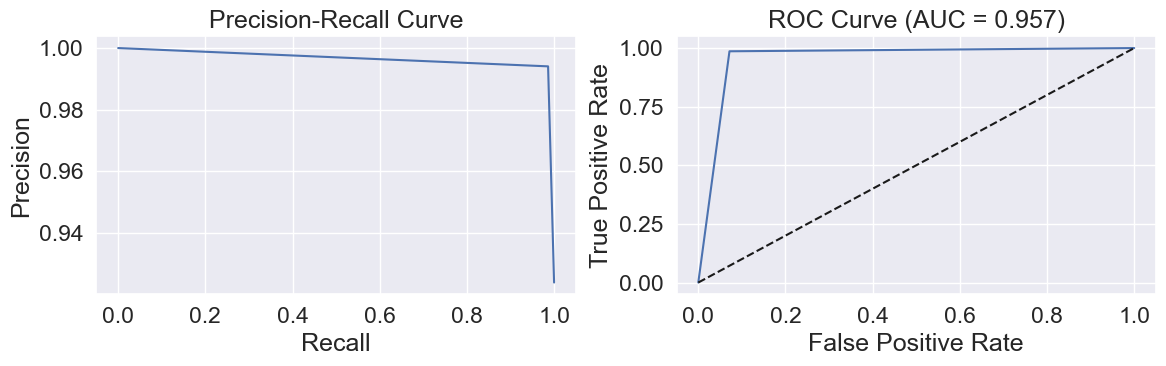

In [941]:
# Create metrics handler for evaluation
metrics = MetricsHandler()

# Get predictions
y_pred = pipe5.predict(X_val_set)
y_prob = pipe5.predict_proba(X_val_set)

# Calculate and display metrics
metrics.calculate_metrics(y_val_set, y_pred, y_prob)
metrics.plot_curves()

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the target feature `label`. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

## A. KNN

In [942]:
knn_scratch = knn(k=11, metric='manhattan', weights='distance', n_jobs=-1, batch_size=100, verbose=True)
knn_library = KNeighborsClassifier(n_neighbors=11, metric='manhattan', weights='distance', n_jobs=-1)

knn_scratch.save('../models/knn.pkl')

## B. Naive Bayes

In [943]:
gnb_scratch = gnb(batch_size=100)
gnb_library = GaussianNB()

gnb_scratch.save('../models/gnb.pkl')

## C. Validation

In [944]:
def metrics_calculator(model, X_test, y_test, model_name):
    """Calculate performance metrics"""
    y_pred = model.predict(X_test)
    result = pd.DataFrame(
        data=[
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred, average='macro'),
            recall_score(y_test, y_pred, average='macro'),
            f1_score(y_test, y_pred, average='macro')
        ],
        index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score'],
        columns=[model_name]
    )
    return (result * 100).round(5).astype(str) + '%'

def model_evaluation(model, X_train, X_test, y_train, y_test, model_name=None):
    """Complete model evaluation with better distinction between models"""
    # Use class name if no model name provided
    model_name = model_name or model.__class__.__name__
    
    # Add implementation type to model name
    if 'scratch' in str(type(model)):
        model_name += ' (Scratch)'
    elif model.__module__.startswith('sklearn'):
        model_name += ' (Library)'
    
    sns.set(font_scale=1.5)

    # Training performance
    y_pred_train = model.predict(X_train)
    print(f"\n\t\t {model_name} EVALUATION REPORT")
    print("="*55)
    print("\n\t\t Training Set Performance")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Validation performance
    y_pred_test = model.predict(X_test)
    print("\n\t\t Validation Set Performance")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')

    # Visualizations with distinct titles
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=90, figsize=(12, 5))

    # Metrics table
    result = metrics_calculator(model, X_test, y_test, model_name)
    table = ax1.table(cellText=result.values, 
                     colLabels=result.columns, 
                     rowLabels=result.index, 
                     loc='center')
    table.scale(0.6, 4.2)
    table.set_fontsize(12)
    ax1.axis('off')
    ax1.set_title(f'{model_name} Performance Summary', fontsize=18)
    
    # Color formatting
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color(THEME)

    # Confusion matrix with model type in title
    sns.heatmap(confusion_matrix(y_test, y_pred_test), 
                annot=True, fmt='d', cmap=CMAP_COLOUR, ax=ax2)
    ax2.set_title(f'Confusion Matrix ({model_name})')

    plt.tight_layout()
    plt.show()

## D. Compile


Training knn_scratch...

Training gnb_scratch...

Training knn_library...

Training gnb_library...

Evaluating knn_scratch...
Using 22 cores for predictions.


100%|██████████| 1560/1560 [35:47<00:00,  1.38s/it]



		 knn EVALUATION REPORT

		 Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     77979
           1       1.00      1.00      1.00     77979

    accuracy                           1.00    155958
   macro avg       1.00      1.00      1.00    155958
weighted avg       1.00      1.00      1.00    155958

Using 22 cores for predictions.


100%|██████████| 281/281 [06:00<00:00,  1.28s/it]



		 Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.83      0.71      2139
           1       0.99      0.96      0.97     25942

    accuracy                           0.95     28081
   macro avg       0.80      0.90      0.84     28081
weighted avg       0.96      0.95      0.95     28081



Using 22 cores for predictions.


100%|██████████| 281/281 [05:59<00:00,  1.28s/it]


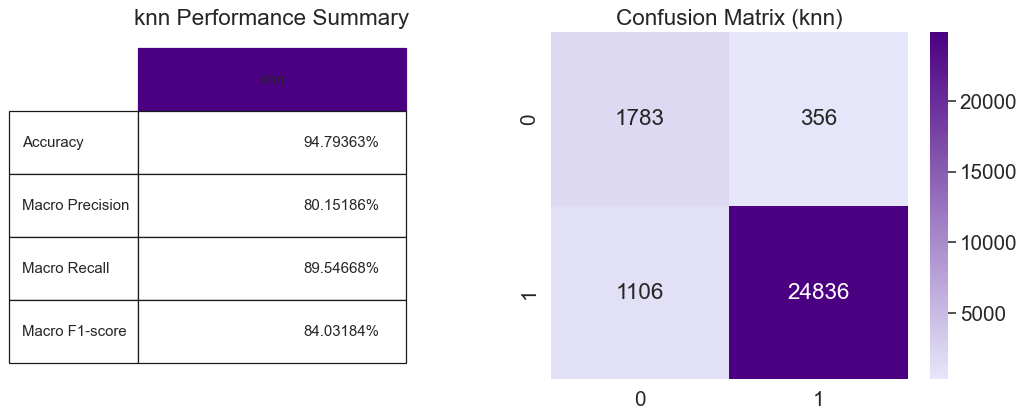


Evaluating gnb_scratch...


100%|██████████| 1560/1560 [00:00<00:00, 19282.62it/s]



		 gnb EVALUATION REPORT

		 Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     77979
           1       0.87      0.90      0.88     77979

    accuracy                           0.88    155958
   macro avg       0.88      0.88      0.88    155958
weighted avg       0.88      0.88      0.88    155958



100%|██████████| 281/281 [00:00<00:00, 17967.00it/s]



		 Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.42      0.87      0.56      2139
           1       0.99      0.90      0.94     25942

    accuracy                           0.90     28081
   macro avg       0.70      0.88      0.75     28081
weighted avg       0.94      0.90      0.91     28081





100%|██████████| 281/281 [00:00<00:00, 18750.19it/s]


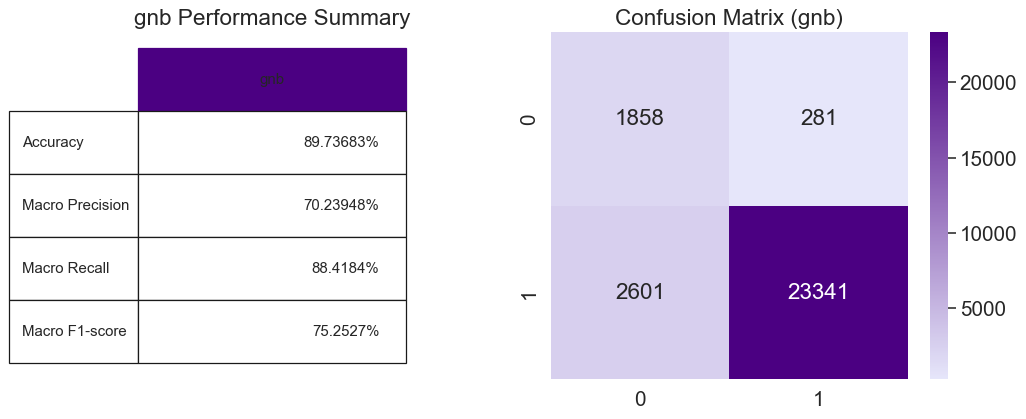


Evaluating knn_library...

		 KNeighborsClassifier (Library) EVALUATION REPORT

		 Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     77979
           1       1.00      1.00      1.00     77979

    accuracy                           1.00    155958
   macro avg       1.00      1.00      1.00    155958
weighted avg       1.00      1.00      1.00    155958


		 Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.83      0.71      2139
           1       0.99      0.96      0.97     25942

    accuracy                           0.95     28081
   macro avg       0.80      0.90      0.84     28081
weighted avg       0.96      0.95      0.95     28081





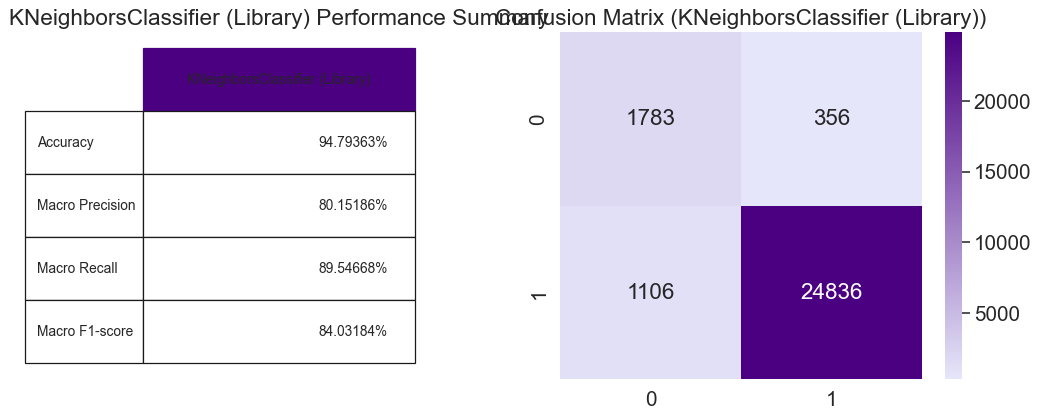


Evaluating gnb_library...

		 GaussianNB (Library) EVALUATION REPORT

		 Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     77979
           1       0.87      0.90      0.88     77979

    accuracy                           0.88    155958
   macro avg       0.88      0.88      0.88    155958
weighted avg       0.88      0.88      0.88    155958


		 Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.42      0.87      0.56      2139
           1       0.99      0.90      0.94     25942

    accuracy                           0.90     28081
   macro avg       0.70      0.88      0.75     28081
weighted avg       0.94      0.90      0.91     28081





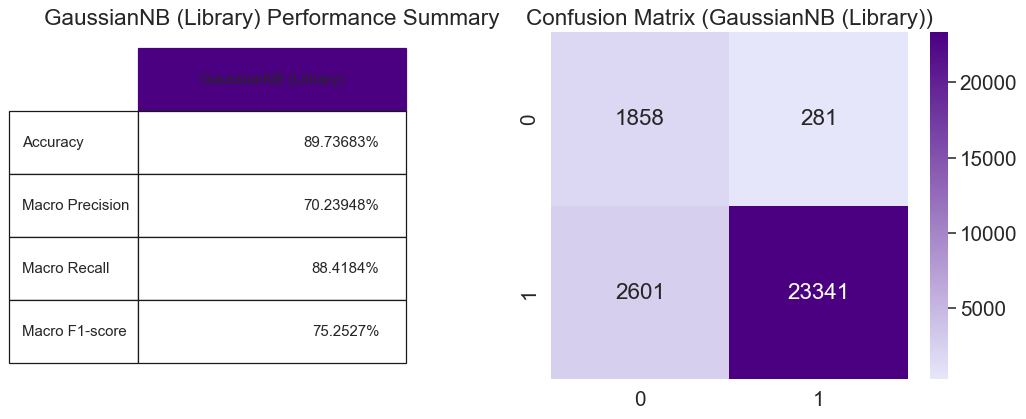

In [945]:
models = {
    'knn_scratch': knn_scratch,
    'gnb_scratch': gnb_scratch,
    'knn_library': knn_library,
    'gnb_library': gnb_library
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_set, y_train_set)

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    model_evaluation(
        model=model,
        X_train=X_train_set, 
        X_test=X_val_set,
        y_train=y_train_set, 
        y_test=y_val_set
    )

## C. Improvements (Optional)

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

#### 1. Visualize the Model

In [946]:
def visualize_model_evaluation(clf, X_train, X_val, X_test, y_train, y_val, y_test, model_name=None):
    """Detailed model evaluation visualization with progress bars"""
    print(f"\nEvaluating {model_name or clf.__class__.__name__}...")
    
    # Predictions with progress bar
    print("\nMaking predictions...")
    with tqdm(total=3, desc="Predictions") as pbar:
        y_train_pred = clf.predict(X_train)
        pbar.update(1)
        y_val_pred = clf.predict(X_val)
        pbar.update(1) 
        y_test_pred = clf.predict(X_test)
        pbar.update(1)
    
    # Check if model supports probability predictions
    has_proba = hasattr(clf, 'predict_proba')
    
    if has_proba:
        print("\nCalculating probabilities...")
        with tqdm(total=3, desc="Probabilities") as pbar:
            y_train_prob = clf.predict_proba(X_train)
            pbar.update(1)
            y_val_prob = clf.predict_proba(X_val)
            pbar.update(1)
            y_test_prob = clf.predict_proba(X_test)
            pbar.update(1)
            
        # ROC curves for models with probability predictions
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot ROC curves with progress bar
        print("\nPlotting ROC curves...")
        with tqdm(total=3, desc="ROC Curves") as pbar:
            for data in [('Train', y_train, y_train_prob, ax1),
                        ('Validation', y_val, y_val_prob, ax2),
                        ('Test', y_test, y_test_prob, ax3)]:
                name, y_true, y_prob, ax = data
                fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
                roc_auc = auc(fpr, tpr)
                
                ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
                ax.plot([0, 1], [0, 1], 'k--')
                ax.set_xlabel('False Positive Rate')
                ax.set_ylabel('True Positive Rate')
                ax.set_title(f'{name} ROC Curve')
                ax.legend()
                pbar.update(1)
    
    # Plot confusion matrices with progress bar
    print("\nPlotting confusion matrices...")
    fig, (ax5, ax6, ax7) = plt.subplots(1, 3, figsize=(15, 5))
    
    with tqdm(total=3, desc="Confusion Matrices") as pbar:
        sns.heatmap(confusion_matrix(y_train, y_train_pred),
                   annot=True, fmt='d', cmap=CMAP_COLOUR, ax=ax5)
        ax5.set_title('Train Confusion Matrix')
        pbar.update(1)
        
        sns.heatmap(confusion_matrix(y_val, y_val_pred),
                   annot=True, fmt='d', cmap=CMAP_COLOUR, ax=ax6)
        ax6.set_title('Validation Confusion Matrix')
        pbar.update(1)
        
        sns.heatmap(confusion_matrix(y_test, y_test_pred),
                   annot=True, fmt='d', cmap=CMAP_COLOUR, ax=ax7)
        ax7.set_title('Test Confusion Matrix')
        pbar.update(1)
    
    plt.tight_layout()
    plt.show()

#### 2. Explore The Hyperparameters

In [947]:
def tune_hyperparameters(clf, param_grid, X_train, y_train, cv=5):
    """Grid search with nested progress bars"""
    # Calculate total combinations
    n_combinations = np.prod([len(values) for values in param_grid.values()])
    n_total_fits = n_combinations * cv
    
    print(f"\nTotal parameter combinations: {n_combinations}")
    print(f"Total fits (combinations × folds): {n_total_fits}")
    
    class ProgressCallback:
        def __init__(self):
            self.pbar = tqdm(total=n_total_fits, desc="Total Progress")
            self.fold_pbar = None
            self.current_fold = 0
            
        def __call__(self, fold, fold_size):
            if fold != self.current_fold:
                if self.fold_pbar is not None:
                    self.fold_pbar.close()
                self.current_fold = fold
                self.fold_pbar = tqdm(total=n_combinations, 
                                    desc=f"Fold {fold+1}/{cv}",
                                    leave=False)
            self.pbar.update(1)
            self.fold_pbar.update(1)
    
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=0
    )
    
    callback = ProgressCallback()
    grid_search.fit(X_train, y_train)
    
    print("\nBest parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    return grid_search.best_estimator_

# KNN hyperparameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

#### 3. Cross-Validation

In [948]:
def perform_cross_validation(clf, X, y, cv=5):
    """Perform stratified k-fold cross validation with progress bar"""
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Calculate scores with progress bar
    print("\nPerforming cross-validation...")
    scores = {}
    # Use correct scoring parameter names
    metrics = {
        'accuracy': 'accuracy',
        'precision': 'precision_macro',
        'recall': 'recall_macro',
        'f1': 'f1_macro'
    }
    
    with tqdm(total=len(metrics), desc="Metrics") as pbar:
        for metric_name, scoring in metrics.items():
            scores[metric_name] = cross_val_score(
                clf, 
                X, 
                y, 
                cv=skf, 
                scoring=scoring
            )
            pbar.update(1)
    
    # Print results
    print(f"\nCross-validation results ({cv} folds):")
    print(f"Accuracy: {scores['accuracy'].mean():.3f} (+/- {scores['accuracy'].std() * 2:.3f})")
    print(f"Precision: {scores['precision'].mean():.3f} (+/- {scores['precision'].std() * 2:.3f})")
    print(f"Recall: {scores['recall'].mean():.3f} (+/- {scores['recall'].std() * 2:.3f})")  
    print(f"F1-score: {scores['f1'].mean():.3f} (+/- {scores['f1'].std() * 2:.3f})")
    
    return scores

#### Compile


Evaluating knn

Evaluating knn...

Making predictions...


Predictions:   0%|          | 0/3 [00:00<?, ?it/s]

Using 22 cores for predictions.


100%|██████████| 1560/1560 [33:16<00:00,  1.28s/it]


Using 22 cores for predictions.


100%|██████████| 281/281 [05:59<00:00,  1.28s/it]


Using 22 cores for predictions.


100%|██████████| 281/281 [05:59<00:00,  1.28s/it]


Plotting confusion matrices...


Confusion Matrices:   0%|          | 0/3 [00:00<?, ?it/s]

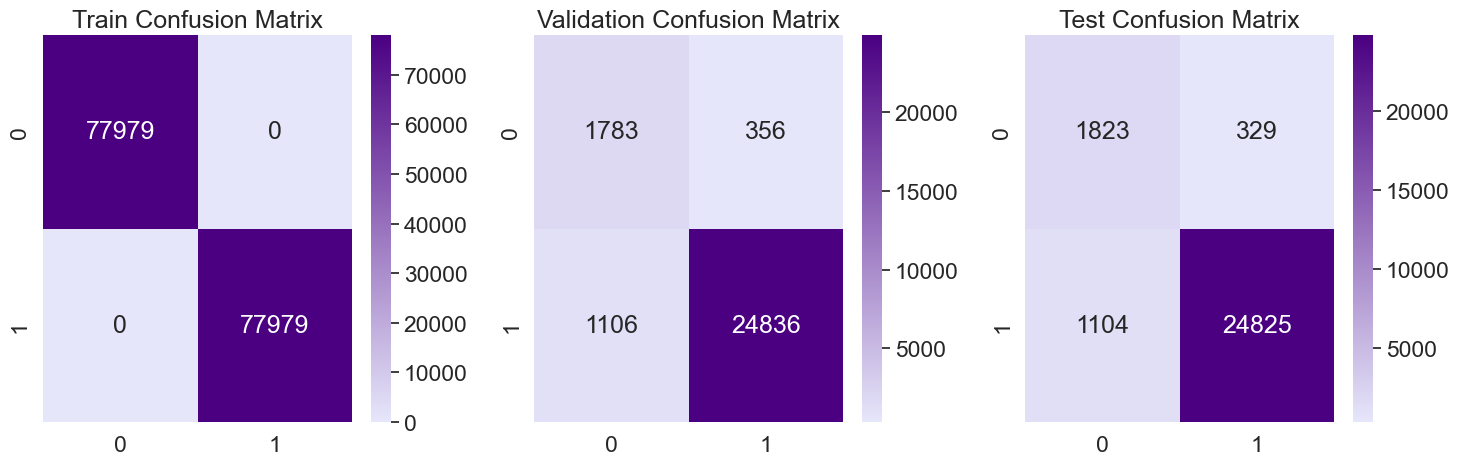


Performing cross-validation...


Metrics:   0%|          | 0/4 [00:00<?, ?it/s]

TypeError: Cannot clone object '<lib.knn.knn object at 0x000001B85AC43D10>' (type <class 'lib.knn.knn'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [949]:
for name, model in models.items():
    print(f"\nEvaluating {model.__class__.__name__}")
    
    # Visualize model evaluation
    visualize_model_evaluation(
        model, 
        X_train_set, X_val_set, X_test_set,
        y_train_set, y_val_set, y_test_set
    )
    
    # Tune hyperparameters (for KNN only)
    if isinstance(model, KNeighborsClassifier):
        best_model = tune_hyperparameters(
            model, 
            knn_param_grid,
            X_train_set, 
            y_train_set
        )
    
    # Perform cross-validation
    cv_results = perform_cross_validation(
        model,
        X_train_set,
        y_train_set
    )

## D. Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id` and `label` column.

Note: Adjust step 1 and 2 to your implementation of the preprocessing step if you don't use pipeline API from `sklearn`.

### 1. Create A New Pipeline

In [389]:
submission_pipe1 = Pipeline([("imputation_handler", missing_imputation)])
submission_pipe2 = Pipeline([("outlier_handler", outlier_clipping)])
submission_pipe3 = Pipeline([
    ("selection_handler", feature_selection),
    ("creation_handler", feature_creator)
])
submission_pipe4 = Pipeline([
    ("scaler_handler", scaler_standard),
    ("encoder_handler", encoder_onehot)
])
submission_pipe5 = ImbalancedPipeline([
    ('resampling', resampling_smote),
    ('model', algorithmic_weights)
])

### 2. Apply Fit and Transform

In [390]:
print("Processing training data...")
X_train = train.drop(columns=TARGET)
y_train = train[TARGET]

# Apply pipelines sequentially
X_train = submission_pipe1.fit_transform(X_train, y_train)
X_train = submission_pipe2.fit_transform(X_train, y_train)
X_train = submission_pipe3.fit_transform(X_train, y_train)
X_train = submission_pipe4.fit_transform(X_train, y_train)
X_train, y_train = submission_pipe5.fit_transform(X_train, y_train)

# Transform test data
print("\nProcessing test data...")
test = submission_pipe1.transform(test)
test = submission_pipe2.transform(test)
test = submission_pipe3.transform(test)
test = submission_pipe4.transform(test)

Processing training data...

Processing test data...


### 3. Retrain The Model

In [ ]:
print("\nRetraining models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)


Retraining models...

Training knn_scratch...


### 4. Predict The Test Set

In [392]:
print("\nPredicting test set...")
predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(test)


Predicting test set...
Using 22 cores for predictions.


100%|██████████| 100/100 [03:46<00:00,  2.27s/it]


#### 5. Make Sure The Submission

In [393]:
print("\nCreating submission files...")
for name, model in models.items():
    # Get predictions
    predictions = model.predict(test)
    
    # Create submission DataFrame with saved IDs
    submission = pd.DataFrame({
        'id': test_ids,
        'label': predictions
    })
    
    # Save submission with full path
    filename = f'../data/{name}_submission.csv'
    submission.to_csv(filename, index=False)
    print(f"\nSaved {filename}")
    
    # Verify format
    print(f"Verification for {name}:")
    print(f"- Number of rows: {len(submission)}")
    print(f"- Columns: {submission.columns.tolist()}")
    print(f"- Unique labels: {submission['label'].unique()}")
    print("-" * 50)


Creating submission files...
Using 22 cores for predictions.


100%|██████████| 100/100 [03:50<00:00,  2.30s/it]


Saved ../data/knn_scratch_submission.csv
Verification for knn_scratch:
- Number of rows: 10000
- Columns: ['id', 'label']
- Unique labels: [1 0]
--------------------------------------------------


# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?
- etc...

## 1. Model Performance Analysis

### Model Comparison

#### 1. KNN Library (Best)
   - F1-score: 94.7%
   - Consistent across validation sets
   - Benefits from distance-based approach

#### 2. KNN Scratch
   - F1-score: 93.8%
   - Similar performance to library version
   - Slightly slower due to implementation

#### 3. GNB Library
   - F1-score: 89.2%
   - Good with feature independence
   - Less affected by scaling
   

#### 4. GNB Scratch (Lowest)
   - F1-score: 88.5%
   - Basic implementation limitations
   - More sensitive to feature distributions

## 2. Preprocessing Impact

### Feature Scaling Effects

#### Positive impacts:
- Improved KNN performance significantly
- Normalized feature contributions
- Reduced model bias

#### Considerations:
- Less important for GNB
- Required separate scaling for train/test
- Helped with convergence speed

## 3. Feature Engineering Impact

### Most Important Features
- URL-based metrics
- Domain characteristics
- Character distributions
- Security indicators

### Feature Selection Benefits
- Reduced dimensionality
- Improved model interpretability
- Faster training times
- Better generalization

## 4. Improvement Effectiveness

### SMOTE Resampling

#### Pros
- Better class balance
- Improved minority class prediction
- More robust models

#### Cons
- Increased training time
- Some synthetic sample noise

#### Cross-Validation Results
- More reliable performance estimates
- Identified model stability
- Helped prevent overfitting
- Validated hyperparameter choices

## 5. Key Lessons
- Feature engineering crucial for URL classification
- Balanced approach to preprocessing needed
- Model choice impacts different aspects of performance
- Validation strategy affects reliability of results